# **STROJNO UČENJE** 22./23.
# Vježba 06 - Stroj potpornih vektora (SVM)

[**Stroj potpornih vektora**](https://en.wikipedia.org/wiki/Support_vector_machine
) (eng. support vector machine, skr. SVM) je algoritam nadziranog učenja dizajniran za binarnu klasifikaciju. Može se koristiti i za višeklasnu klasifikaciju - u tom slučaju se instancira [više binarnih klasifikatora](https://scikit-learn.org/stable/modules/svm.html#multi-class-classification).

SVM radi na način da pokušava ispravno klasificirati što je više moguće primjeraka iz skupa podataka za treniranje - na način da prilagođava parametre koji definiraju granicu između klasa.

Granica između klasa kod *linearnog* SVM je hiperravnina, a kod SVM algoritama koji koriste druge funkcije je nelinearna ploha.

Dakle, SVM povlači granicu (eng. [decision boundary](https://en.wikipedia.org/wiki/Decision_boundary)) između klasa koje uči razdijeliti.

Način na koji algoritam radi možemo predstaviti najlakše geometrijski:

![margina](https://drive.google.com/uc?id=1ouqDJTLYKFjQeqNRi0j11yusq5J3bheh)

- parametar $\gamma$ predstavlja širinu margine - strogoću klasifikacije
- **$w$** označava vektor normale na hiperravninu - usmjerenost hiperravnine
- točke na rubovima margine nazivaju se **potporni vektori** (eng. support vectors) - jer "podupiru" ravninu.

> [Osnovna matematička formulacija](https://scikit-learn.org/stable/modules/svm.html#mathematical-formulation) se nalazi na *sklearn* stranici dokumentacije.

## Klasifikacija vrsta pingvina

Radimo višeklasnu klasifikaciju pomoću 4 numeričke i 2 kategoričke značajke.

3 klase su vrste pingvina $\in \{$ Adelie, Gentoo, Chinstrap$\}$.

> "*If [species] ‘Gentoo’ sounds familiar that is because Gentoo Linux is named after it!*"

### Upoznavanje s podacima

In [15]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/strojno_ucenje_2223/vj_06/penguins_size.csv')
data.head(5)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [16]:
data.shape

(344, 7)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [18]:
categorical = ['species', 'island', 'sex']
numerical = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

In [19]:
data.duplicated().sum()

0

In [20]:
data.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [21]:
data.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [22]:
data.nunique()

species                3
island                 3
culmen_length_mm     164
culmen_depth_mm       80
flipper_length_mm     55
body_mass_g           94
sex                    3
dtype: int64

In [23]:
for col in categorical:
  print('#'*40, '\n', col)
  print(data[col].unique())

######################################## 
 species
['Adelie' 'Chinstrap' 'Gentoo']
######################################## 
 island
['Torgersen' 'Biscoe' 'Dream']
######################################## 
 sex
['MALE' 'FEMALE' nan '.']


In [24]:
data[data['sex'].isna()]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


In [25]:
data[data['sex']=='.']

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


In [26]:
# data imputation

data.at[336,'sex'] = data['sex'].mode()[0]

data.loc[data['sex'].isna(), 'sex'] = data['sex'].mode()[0]

for col in numerical:
  data.loc[data[col].isna(), col] = data[col].mean()

data.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

### Vizualizacija

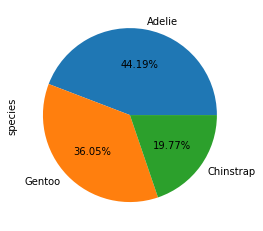

In [27]:
Species=data.species.value_counts()
Species.plot(kind='pie', autopct="%.2f%%")

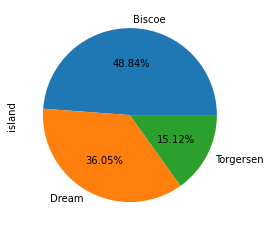

In [28]:
Island=data.island.value_counts()
Island.plot(kind='pie',autopct="%.2f%%")

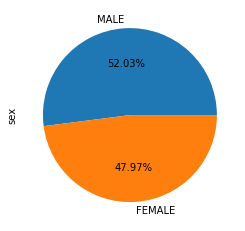

In [29]:
Sex=data.sex.value_counts()
Sex.plot(kind='pie',autopct="%.2f%%")

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set(rc = {"figure.figsize": (10,6), "figure.dpi" : 100})

# https://stackoverflow.com/questions/47633546/relationship-between-dpi-and-figure-size

In [31]:
# import warnings
# warnings.filterwarnings("ignore")

Text(0.5, 1.0, 'Culmen Length vs Culmen Depth')

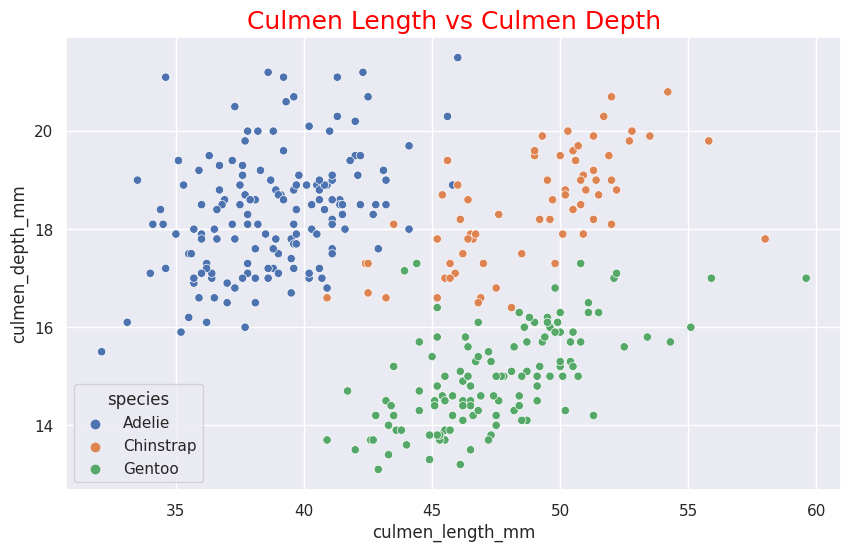

In [32]:
sns.scatterplot(x="culmen_length_mm", y="culmen_depth_mm", data=data, hue="species")
plt.title("Culmen Length vs Culmen Depth", size=18, color="red")

> Parametar *kde* označava [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) - procjena gustoće, odnosno razdiobe kontinuirane slučajne varijable.

Text(0.5, 1.0, 'Flipper Length')

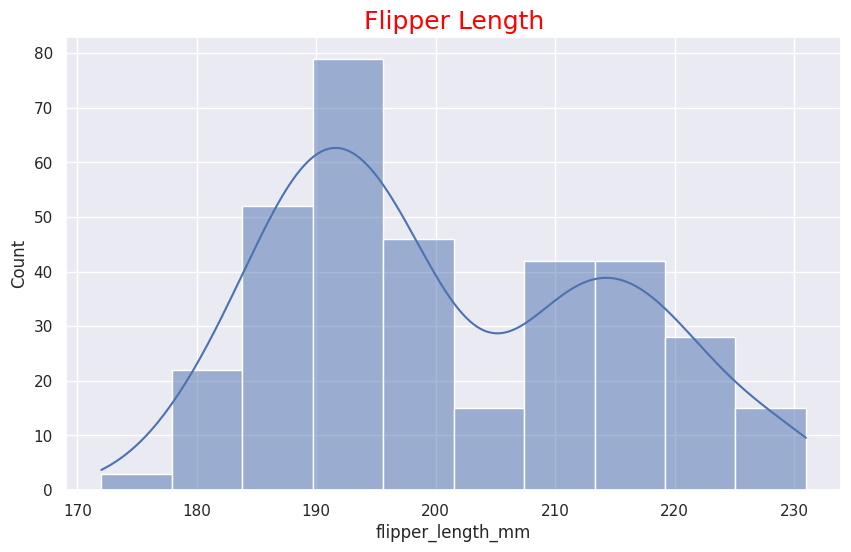

In [33]:
sns.histplot(x = "flipper_length_mm", data = data, kde = True)
plt.title("Flipper Length", size=18, color="red")

Text(0.5, 1.0, 'Flipper Length')

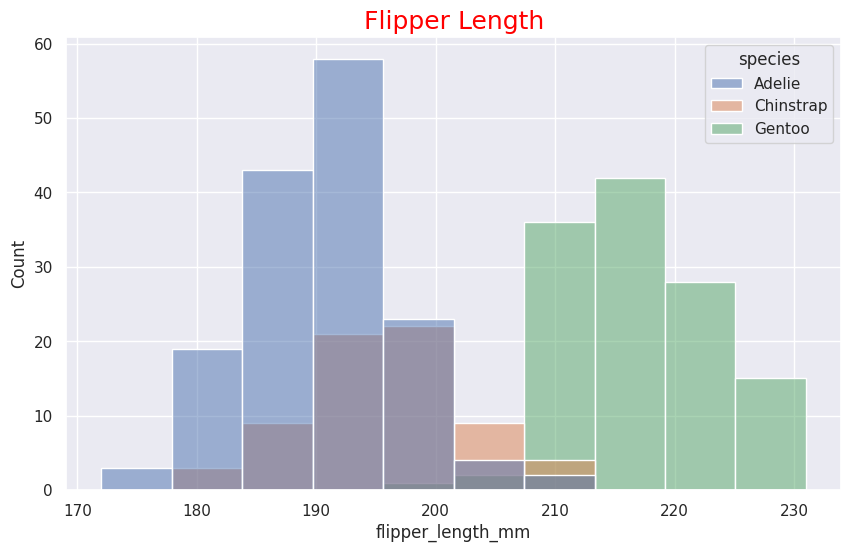

In [34]:
sns.histplot(x = "flipper_length_mm", data = data, hue = "species")
plt.title("Flipper Length", size=18, color="red")

Text(0.5, 1.0, 'Flipper Length for 3 Penguin Species')

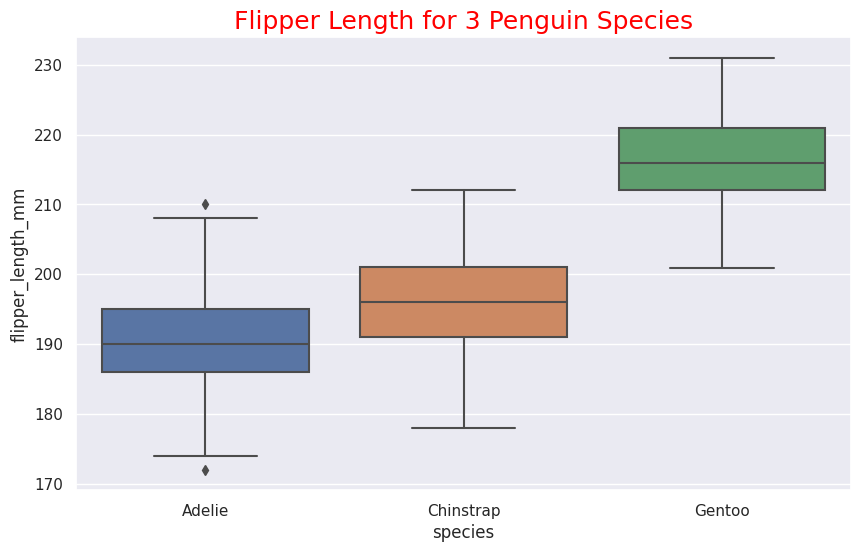

In [35]:
sns.boxplot(x = "species", y = "flipper_length_mm", data =data)
plt.title("Flipper Length for 3 Penguin Species", size=18, color="red")

Text(0.5, 1.0, 'Flipper Length for 3 Penguin Species by Sex')

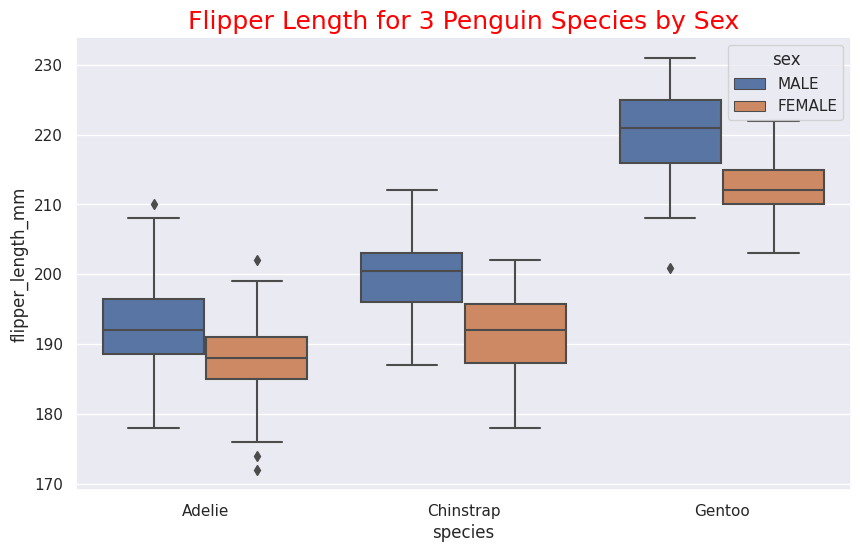

In [36]:
sns.boxplot(x = "species", y = "flipper_length_mm", data =data, hue = "sex")
plt.title("Flipper Length for 3 Penguin Species by Sex", size=18, color="red")

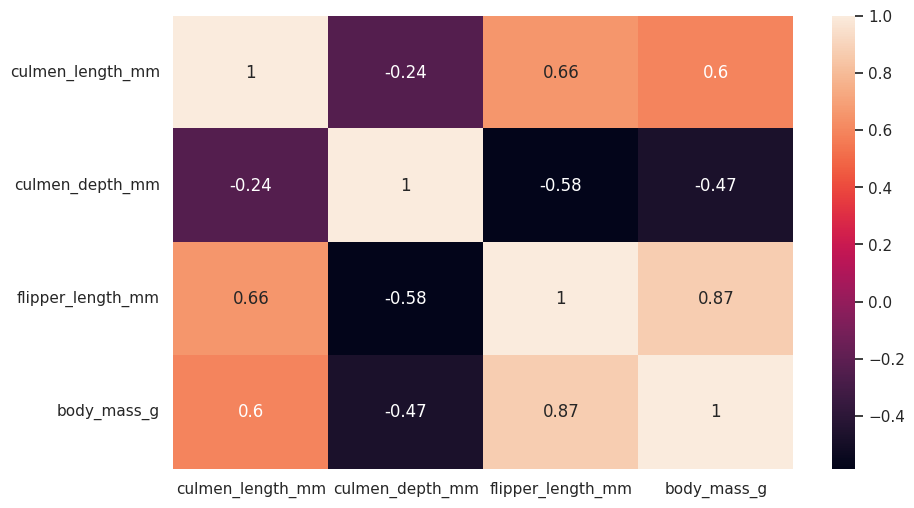

In [37]:
sns.heatmap(data.corr(), annot = True)

### Model

In [38]:
# kodiranje kategoričkih varijabli

data['sex'].replace('MALE', 0, inplace=True)
data['sex'].replace('FEMALE', 1, inplace=True)

data['island'].replace('Torgersen', 0, inplace=True)
data['island'].replace('Biscoe', 1, inplace=True)
data['island'].replace('Dream', 2, inplace=True)

data['species'].replace('Adelie', 0, inplace=True)
data['species'].replace('Chinstrap', 1, inplace=True)
data['species'].replace('Gentoo', 2, inplace=True)

# trebat će nam poslije
data1 = data[['species', 'flipper_length_mm', 'culmen_length_mm']].sample(n=150)

In [39]:
# zavisna varijabla = 'species'

y = data['species']
X = data.drop('species', axis=1)

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape

((240, 6), (104, 6))

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = svm.SVC(gamma='auto')
clf.fit(X_train, y_train)

SVC(gamma='auto')

In [42]:
# # 2. nacin

# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn import svm

# clf = make_pipeline(StandardScaler(), svm.SVC(gamma='auto'))
# clf.fit(X_train, y_train)

In [43]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
print('točnost (test): ', accuracy_score(y_pred, y_test))

točnost (test):  0.9903846153846154


parametri sklearn:
- C - jačina $l_2$ regularizacije (automatski se uvijek primijenjuje ova regularizacija)
- kernel - tip jezgrene funkcije $\in \{$ 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'$\}$
- degree - stupanj polinomijalne jezgrene funkcije (za kernel='poly')
- gamma - koeficijent za 'rbf', 'poly', 'sigmoid' jezgrene funkcije

In [44]:
print('zadani (default) parametri:\n')
clf.get_params()

zadani (default) parametri:



{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [45]:
print('\nbroj potpornih vektora za svaku klasu redom: ', clf.n_support_)
print('\npotporni vektori:\n\n', clf.support_vectors_)


broj potpornih vektora za svaku klasu redom:  [23 17 12]

potporni vektori:

 [[-0.34956332  0.29526046  1.62842447 -0.72010854  0.49011106 -0.96720415]
 [ 1.14856519 -0.80863515 -0.19441789 -1.63456365 -1.19654793  1.03390789]
 [-1.84769183 -0.19334907  0.2612927  -0.36839504  0.61504877 -0.96720415]
 [-1.84769183 -1.46011452 -0.2450524  -0.79045124 -1.44642333  1.03390789]
 [ 1.14856519 -0.32002562  0.71700329 -1.49387825 -0.82173482  1.03390789]
 [ 1.14856519 -1.20676143 -0.14378338 -0.64976584 -1.50889218  1.03390789]
 [-1.84769183 -0.6819586  -0.04251436 -1.77524905 -0.94667252  1.03390789]
 [-1.84769183  0.02381072  0.46383074  0.61640277 -0.25951515 -0.96720415]
 [-0.34956332 -0.77244185  0.31192721 -0.57942314 -1.25901678  1.03390789]
 [-0.34956332 -0.22954237  0.61573427 -0.36839504 -0.16581188 -0.96720415]
 [ 1.14856519 -2.14778719 -0.80203201 -0.93113664 -1.44642333  1.03390789]
 [ 1.14856519 -0.57337871  0.91954133  0.47571737  0.11529796 -0.96720415]
 [ 1.14856519 -0.9172

### Vizualizacija algoritma

In [46]:
X = data1[['flipper_length_mm', 'culmen_length_mm']].to_numpy()
y = data1['species'].to_numpy()

In [47]:
svc = svm.SVC(kernel='linear').fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3).fit(X, y)
lin_svc = svm.LinearSVC().fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [48]:
import numpy as np

h = .02  # step size in the mesh

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

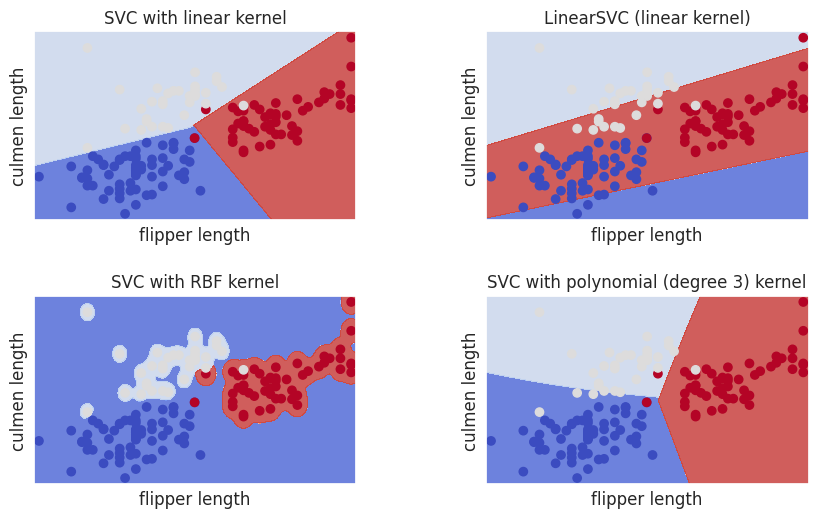

In [49]:
for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('flipper length')
    plt.ylabel('culmen length')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

## Iteriranje hiperparametara

Na prošlim vježbama smo vidjeli primjer korištenja [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) za pronalaženje modela s najboljim hiperparametrima od ponuđenih kombinacija. Danas nadograđujemo to znanje s ekstenzivnijim i realističnijim primjerom - prolazimo više kombinacija hiperparametara.

S obzirom da je prethodni skup podataka prejednostavan i klasifikator ga odmah dobro nauči, učitat ćemo kompliciraniji skup podataka kako bismo vidjeli važnost izbora dobrih hiperparametara bolje.

Koristimo *adult.csv* podatke otprije, s kojima smo već upoznati.

In [7]:
# učitavanje podataka
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
data = pd.read_csv('/content/drive/MyDrive/strojno_ucenje_2223/vj_04/adult.csv', header=None)

# čišćenje podataka
data.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship',
                'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

data['workclass'].replace(' ?', np.nan, inplace=True)
data['occupation'].replace(' ?', np.nan, inplace=True)
data['native_country'].replace(' ?', np.nan, inplace=True)

# odabir zavisne varijable
X = data.drop(['income'], axis=1)
y = data['income']

# podjela skupa podataka na podatke za treniranje i testiranje
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# data imputation
for df in [X_train, X_test]:
    df['workclass'].fillna(X_train['workclass'].mode()[0], inplace=True)
    df['occupation'].fillna(X_train['occupation'].mode()[0], inplace=True)
    df['native_country'].fillna(X_train['native_country'].mode()[0], inplace=True)

In [8]:
!pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# kodiranje kategoričkih varijabli

from feature_engine.encoding import CountFrequencyEncoder

categorical_variables = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

encoder = CountFrequencyEncoder(encoding_method='count')
encoder.fit(X_train[categorical_variables])
X_train[categorical_variables] = encoder.transform(X_train[categorical_variables])
X_test[categorical_variables] = encoder.transform(X_test[categorical_variables])

y_train.replace(' >50K', 0, inplace=True)
y_train.replace(' <=50K', 1, inplace=True)
y_test.replace(' >50K', 0, inplace=True)
y_test.replace(' <=50K', 1, inplace=True)

In [10]:
# skaliranje numeričkih varijabli
from sklearn.preprocessing import StandardScaler

numerical_variables = set(X_train.columns) - set(categorical_variables)
numerical_variables = list(numerical_variables)

scaler = StandardScaler()
scaler.fit(X_train[numerical_variables])
X_train[numerical_variables] = scaler.transform(X_train[numerical_variables])
X_test[numerical_variables] = scaler.transform(X_test[numerical_variables])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

param_grid = [{'C': [1, 0.1], 'kernel': ['linear']}]

svc = svm.SVC()
grid_clf = GridSearchCV(svc, param_grid, verbose=2, cv=3)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .................................C=1, kernel=linear; total time= 7.3min
[CV] END .................................C=1, kernel=linear; total time= 5.0min
[CV] END .................................C=1, kernel=linear; total time= 4.6min
[CV] END ...............................C=0.1, kernel=linear; total time= 3.4min
[CV] END ...............................C=0.1, kernel=linear; total time= 3.0min
[CV] END ...............................C=0.1, kernel=linear; total time= 3.0min


GridSearchCV(cv=3, estimator=SVC(),
             param_grid=[{'C': [1, 0.1], 'kernel': ['linear']}], verbose=2)

In [ ]:
param_grid2 = [{'C': [1, 0.1], 'kernel': ['rbf']}]

svc = svm.SVC()
grid_clf2 = GridSearchCV(svc, param_grid2, verbose=2, cv=3)
grid_clf2.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ....................................C=1, kernel=rbf; total time=  14.0s
[CV] END ....................................C=1, kernel=rbf; total time=  14.1s
[CV] END ....................................C=1, kernel=rbf; total time=  15.4s
[CV] END ..................................C=0.1, kernel=rbf; total time=  13.7s
[CV] END ..................................C=0.1, kernel=rbf; total time=  20.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=  18.1s


GridSearchCV(cv=3, estimator=SVC(),
             param_grid=[{'C': [1, 0.1], 'kernel': ['rbf']}], verbose=2)

In [11]:
param_grid3 = [{'C': [1, 0.1], 'degree': [2, 5], 'kernel': ['poly']}]

svc = svm.SVC()
grid_clf3 = GridSearchCV(svc, param_grid3, verbose=2, cv=3)
grid_clf3.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .........................C=1, degree=2, kernel=poly; total time=  15.6s
[CV] END .........................C=1, degree=2, kernel=poly; total time=  13.3s
[CV] END .........................C=1, degree=2, kernel=poly; total time=   9.3s
[CV] END .........................C=1, degree=5, kernel=poly; total time=   9.8s
[CV] END .........................C=1, degree=5, kernel=poly; total time=  10.6s
[CV] END .........................C=1, degree=5, kernel=poly; total time=   9.7s
[CV] END .......................C=0.1, degree=2, kernel=poly; total time=   9.2s
[CV] END .......................C=0.1, degree=2, kernel=poly; total time=   9.1s
[CV] END .......................C=0.1, degree=2, kernel=poly; total time=  10.6s
[CV] END .......................C=0.1, degree=5, kernel=poly; total time=  11.6s
[CV] END .......................C=0.1, degree=5, kernel=poly; total time=   9.1s
[CV] END .......................C=0.1, degree=5, 

GridSearchCV(cv=3, estimator=SVC(),
             param_grid=[{'C': [1, 0.1], 'degree': [2, 5], 'kernel': ['poly']}],
             verbose=2)

In [12]:
param_grid4 = [{'C': [1, 0.1], 'kernel': ['sigmoid']}]

svc = svm.SVC()
grid_clf4 = GridSearchCV(svc, param_grid4, verbose=2, cv=3)
grid_clf4.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ................................C=1, kernel=sigmoid; total time=  26.6s
[CV] END ................................C=1, kernel=sigmoid; total time=  33.4s
[CV] END ................................C=1, kernel=sigmoid; total time=  26.4s
[CV] END ..............................C=0.1, kernel=sigmoid; total time=  24.0s
[CV] END ..............................C=0.1, kernel=sigmoid; total time=  19.2s
[CV] END ..............................C=0.1, kernel=sigmoid; total time=  20.0s


GridSearchCV(cv=3, estimator=SVC(),
             param_grid=[{'C': [1, 0.1], 'kernel': ['sigmoid']}], verbose=2)

> **Napomena:** Uvijek je dobro pročitati dokumentaciju softvera kojeg koristite kako biste znali koliko dugo izvršavanje koda možete očekivati, i o čemu to vrijeme izvršavanja potencijalno ovisi.

Pogledajmo koji su najbolji klasifikatori od ovih koje smo isprobali.

In [13]:
print('Linearna jezgra:', grid_clf.best_estimator_)
print('RBF jezgra:', grid_clf2.best_estimator_)
print('Polinomijalna jezgra:', grid_clf3.best_estimator_)
print('Sigmoidna jezgra:', grid_clf4.best_estimator_)

Linearna jezgra: SVC(C=0.1, kernel='linear')
RBF jezgra: SVC(C=1)
Polinomijalna jezgra: SVC(C=1, degree=5, kernel='poly')
Sigmoidna jezgra: SVC(C=1, kernel='sigmoid')


In [14]:
print('Linearna jezgra:', grid_clf.best_score_)
print('RBF jezgra:', grid_clf2.best_score_)
print('Polinomijalna jezgra:', grid_clf3.best_score_)
print('Sigmoidna jezgra:', grid_clf4.best_score_)

Linearna jezgra: 0.7856701191800807
RBF jezgra: 0.7677694534732561
Polinomijalna jezgra: 0.7886976415892407
Sigmoidna jezgra: 0.6935365690513251


Prema ovim rezultatima, najbolji izbor za ovaj problem se čini linearni klasifikator ili SVM s polinomijalnom jezgrom. No, možda za neke druge hiperparametre bi drugi modeli nadmašili ove! Zato je dobro pomno izabrati hiperparametre modela, i sami model.

**1. Kako izabrati dobre hiperparametre?**

S obzirom da uspješnost modela ovisi uvelike o slučaju, tj. o podacima koje koristimo i o problemu kojeg rješavamo, ne postoje standardno dobri hiperparametri koji su prikladni za svaku situaciju. Iz tog razloga koristimo pretragu hiperparametara (eng. hyperparameter tuning) - pomoću pretrage mreže mogućih kombinacija hiperparametara (eng. grid search).

**2. Koje hiperparametre isprobati?**

U pretragu je često dobro uključiti zadane (eng. default) vrijednosti parametara (koje možemo pronaći u dokumentaciji softvera kojeg koristimo za implementaciju algoritma). Postoje poneki zaključci o situacijama kad je neki hiperparametar prikladan, ali najsigurnije je isprobati nekoliko vrijednosti za svaki od njih.
> Npr., zadana vrijednost regularizacijskog hiperparametra *C* je jednaka 1. U pretragu hiperparametara uključujemo onda 1, i isprobavamo neki drugi broj koji bi mogao biti prikladan, primjerice 0.1 ili 10.

Započinjemo na maloj mreži hiperparametara (onoj koja ne sadrži previše kombinacija), sa velikim rasponom vrijednosti hiperparametara. Nakon što provedemo jednu pretragu, zaključujemo koje kombinacije su dale najbolje rezultate.

Ukoliko još želimo poboljšati izbor hiperparametara, ponovno vršimo pretragu, ali ovaj put koncentrirano na pronađenoj "dobroj" regiji kombinacija vrijednosti.

> Npr., ako su rezultati prve pretrage pokazali da najbolji model dobivamo za kombinaciju hiperparametara *C*=1 i *gamma*=0.1, onda isprobavamo vrijednosti *blizu* tih, recimo *C* $\in \{$ 0.5, 2 $\}$, *gamma* $\in \{$ 0.01, 0.2 $\}$, a ne, recimo, *C*=100, *gamma*=5.

**3. Kada stati s pretragom hiperparametara?**

Kada je dostignuta dovoljna kvaliteta modela (po odabranoj metrici). Npr., kada prijeđemo 80% točnosti, ili 90% točnosti, ili smanjimo RMSE na ~2, ili smanjimo RMSE na ~200. Sve ovisi o podacima i konkretnom problemu.

ILI

Kada traženje hiperparametara ne mijenja mnogo kvalitetu modela. Npr., isprobano je 20 kombinacija hiperparametara, ali svi daju točnost klasifikacije otprilike 85%.